## Shared Bike Demand Prediction - Assignment Solution

The solution is divided into the following sections: 
- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation



### 1. Data Understanding and Exploration

Let's first import the required libraries and have a look at the dataset and understand the size, attribute names etc.

In [447]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [448]:
import warnings
warnings.filterwarnings('ignore')

In [449]:
# Reading the dataset
bikes_shared = pd.read_csv("day.csv")

In [450]:
# Let's take a look at the first few rows
bikes_shared.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

In [451]:
# finding the shape of our dataset
bikes_shared.shape

(730, 16)

In [452]:
# Summary of the dataset: 730 rows, 16 columns, no null values
print(bikes_shared.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
instant       730 non-null int64
dteday        730 non-null object
season        730 non-null int64
yr            730 non-null int64
mnth          730 non-null int64
holiday       730 non-null int64
weekday       730 non-null int64
workingday    730 non-null int64
weathersit    730 non-null int64
temp          730 non-null float64
atemp         730 non-null float64
hum           730 non-null float64
windspeed     730 non-null float64
casual        730 non-null int64
registered    730 non-null int64
cnt           730 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB
None


In [453]:
# describing the dataset
bikes_shared.describe()

instant      season          yr        mnth     holiday     weekday  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean   365.500000    2.498630    0.500000    6.526027    0.028767    2.997260   
std    210.877136    1.110184    0.500343    3.450215    0.167266    2.006161   
min      1.000000    1.000000    0.000000    1.000000    0.000000    0.000000   
25%    183.250000    2.000000    0.000000    4.000000    0.000000    1.000000   
50%    365.500000    3.000000    0.500000    7.000000    0.000000    3.000000   
75%    547.750000    3.000000    1.000000   10.000000    0.000000    5.000000   
max    730.000000    4.000000    1.000000   12.000000    1.000000    6.000000   

       workingday  weathersit        temp       atemp         hum   windspeed  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean     0.683562    1.394521   20.319259   23.726322   62.765175   12.763620   
std      0.465405    0.544807    7.506729    8.150308   14.237589    5.195841   
min      0.000000    1.000000    2.424346    3.953480    0.000000    1.500244   
25%      0.000000    1.000000   13.811885   16.889713   52.000000    9.041650   
50%      1.000000    1.000000   20.465826   24.368225   62.625000   12.125325   
75%      1.000000    2.000000   26.880615   30.445775   72.989575   15.625589   
max      1.000000    3.000000   35.328347   42.044800   97.250000   34.000021   

            casual   registered          cnt  
count   730.000000   730.000000   730.000000  
mean    849.249315  3658.757534  4508.006849  
std     686.479875  1559.758728  1936.011647  
min       2.000000    20.000000    22.000000  
25%     316.250000  2502.250000  3169.750000  
50%     717.000000  3664.500000  4548.500000  
75%    1096.500000  4783.250000  5966.000000  
max    3410.000000  6946.000000  8714.000000

#### Understanding the Data Dictionary

The data dictionary contains the meaning of various attributes; some non-obvious ones are:

day.csv have the following fields:
	
	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

## Step 2: Visualising the Data

Let's now spend some time doing what is arguably the most important step - **understanding the data**.
- If there is some obvious multicollinearity going on, this is the first place to catch it
- Here's where you'll also identify if some predictors directly have a strong association with the outcome variable

We'll visualise our data using `matplotlib` and `seaborn`.

#### Visualising Numeric Variables

Let's make a pairplot of all the numeric variables

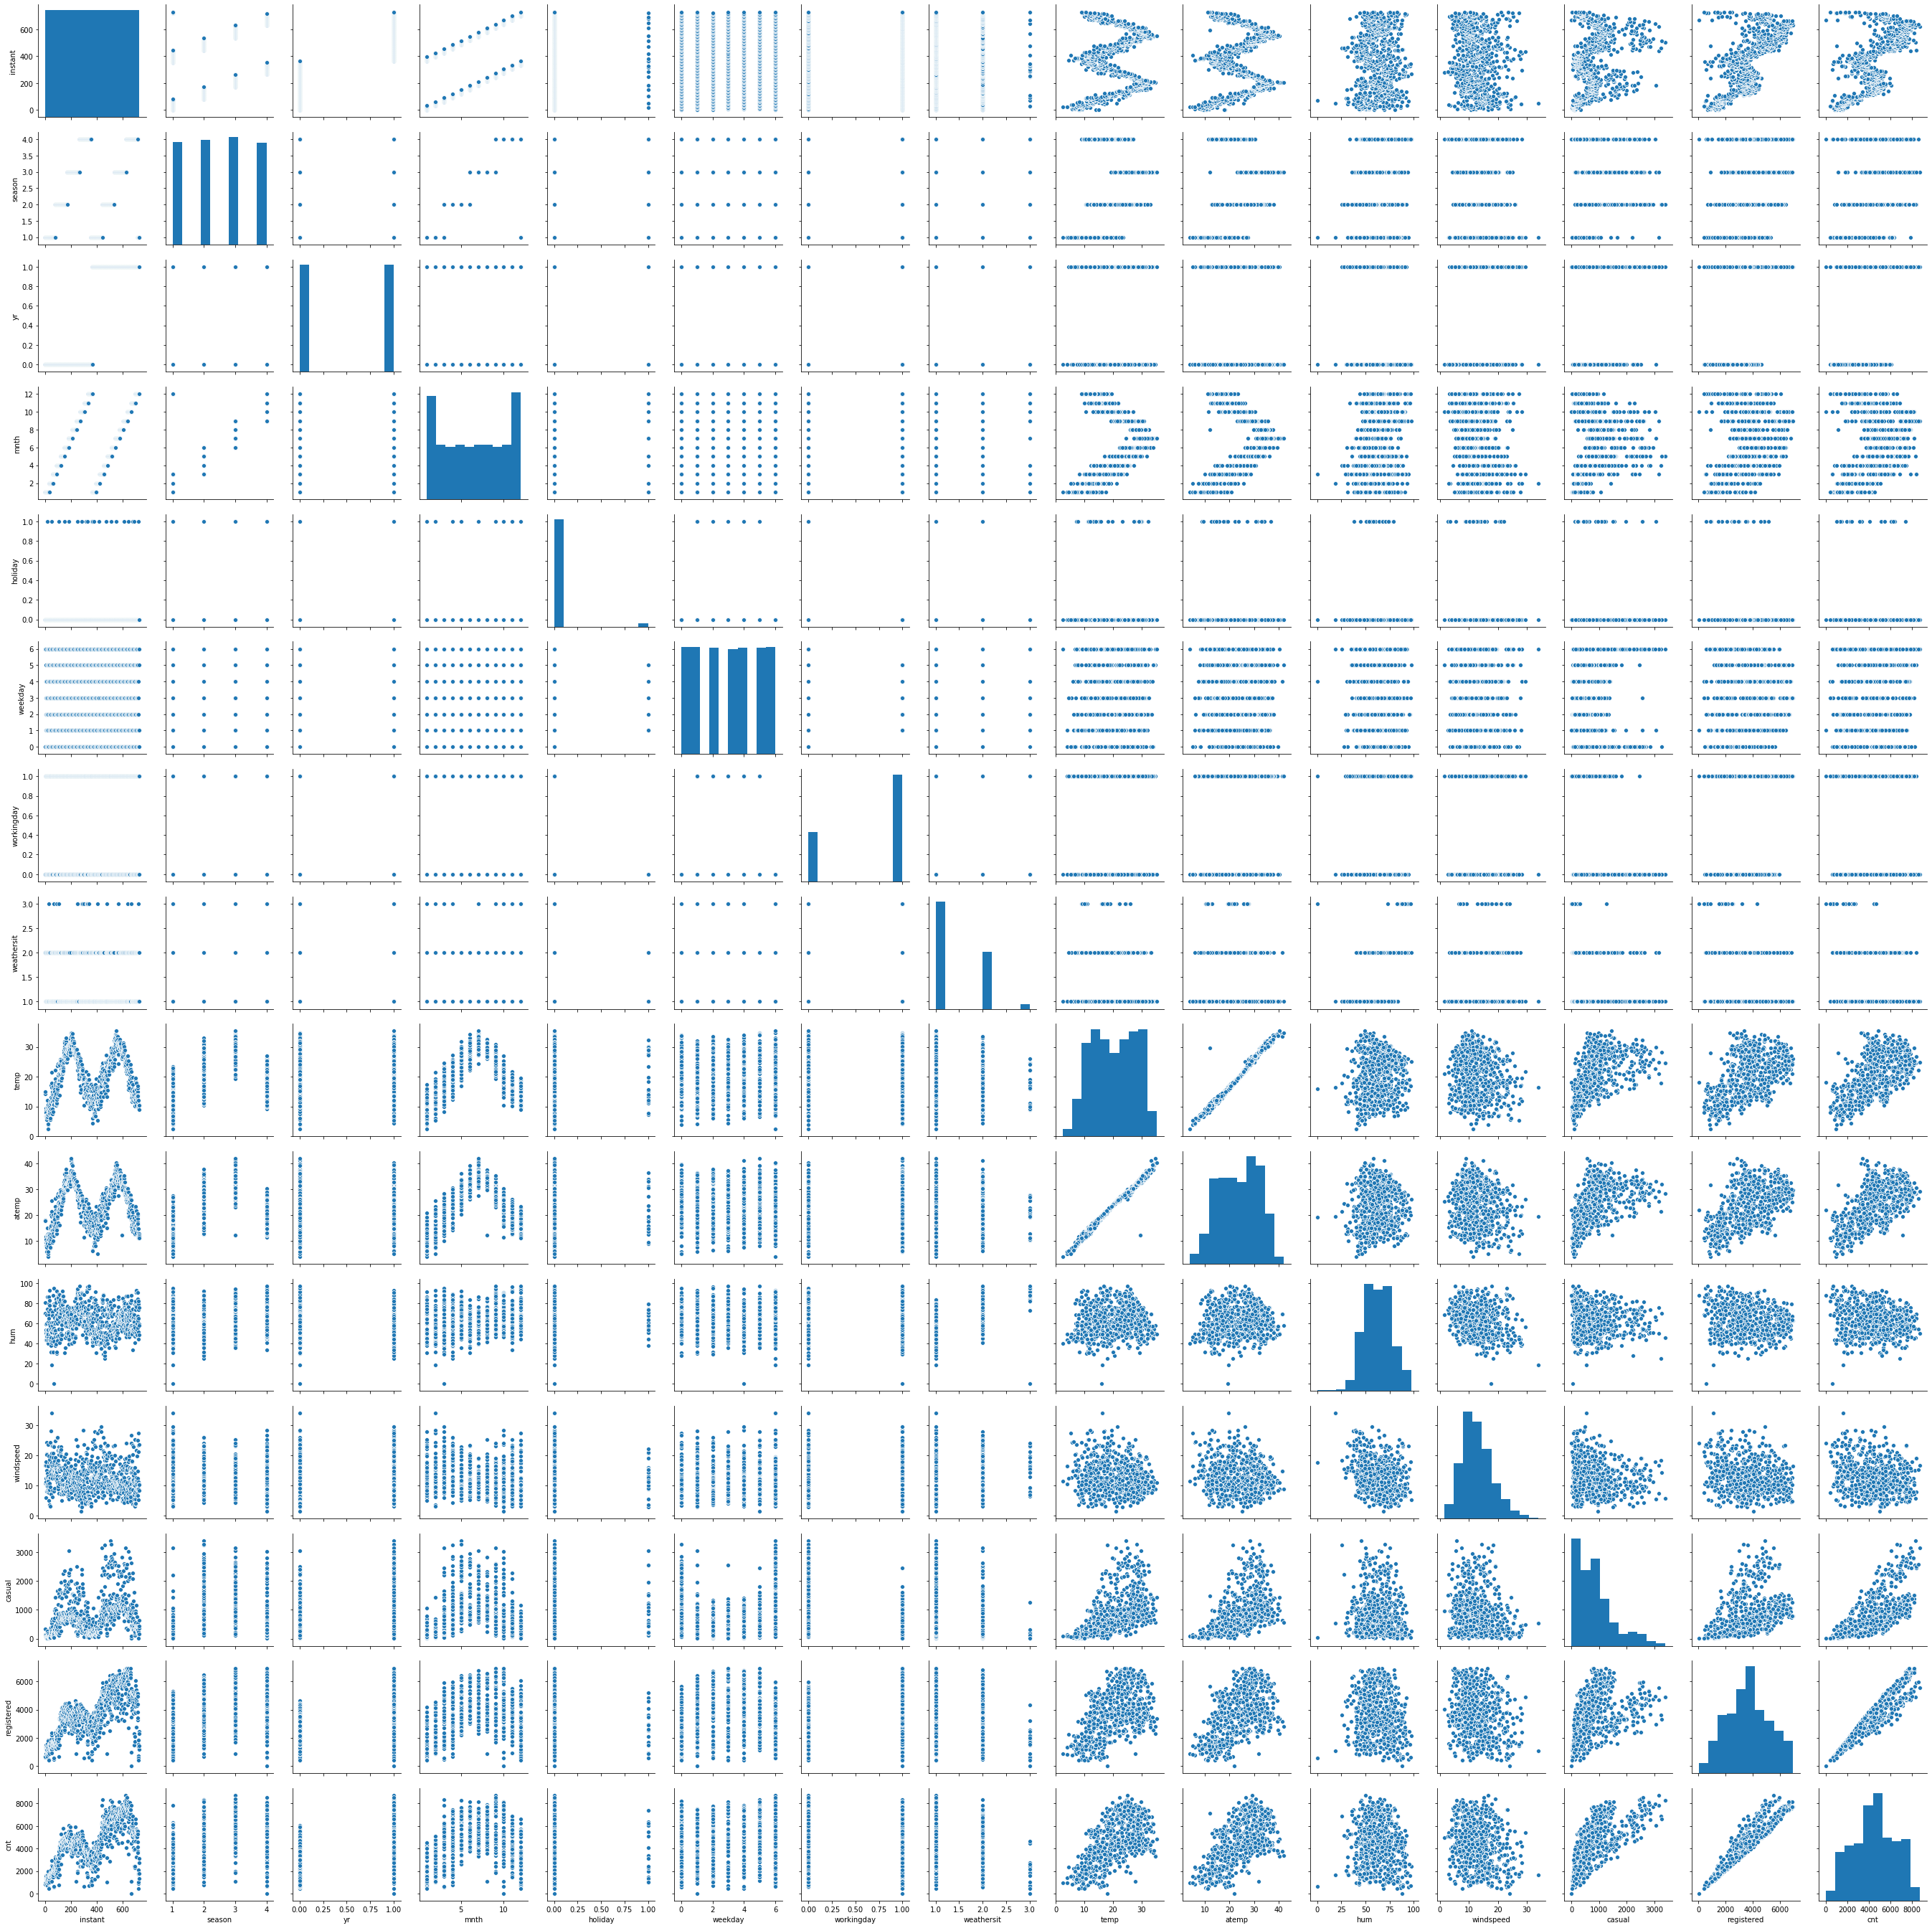

In [359]:

sns.pairplot(bikes_shared)
plt.show()

#### Visualising Categorical Variables

As you might have noticed, there are a few categorical variables as well. Let's make a boxplot for some of these variables.

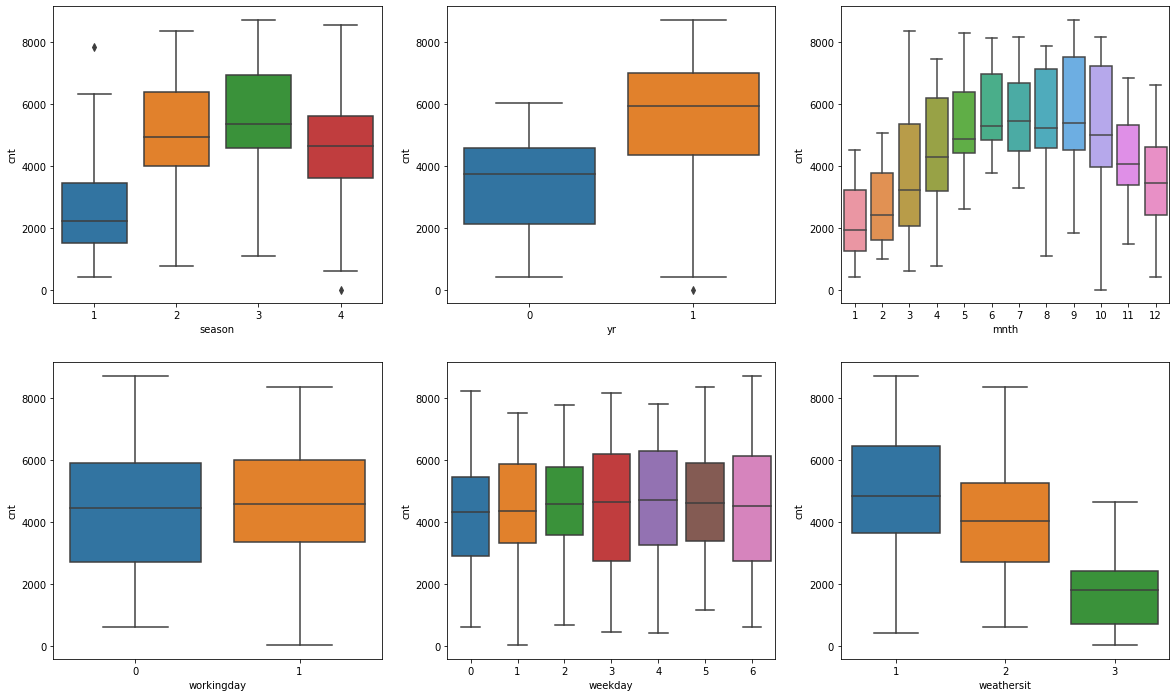

In [9]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = bikes_shared)
plt.subplot(2,3,2)
sns.boxplot(x = 'yr', y = 'cnt', data = bikes_shared)
plt.subplot(2,3,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = bikes_shared)
plt.subplot(2,3,4)
sns.boxplot(x = 'workingday', y = 'cnt', data = bikes_shared)
plt.subplot(2,3,5)
sns.boxplot(x = 'weekday', y = 'cnt', data = bikes_shared)
plt.subplot(2,3,6)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bikes_shared)
plt.show()

We can also visualise some of these categorical features parallely by using the `hue` argument. Below is the plot for `weathersit` with `workingday` as the hue.


In [ ]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'season', y = 'cnt', hue = 'workingday', data = bikes_shared)
plt.show()

## Step 3: Data Preparation

-In order to fit a regression line, we would need numerical values and not string. Hence, we need to convert them to 1s and 0s. 
You can see that your dataset has many columns with values as 'Yes' or 'No'.

- But , where 1 is a 'Yes' and 0 is a 'No'.

In [454]:
# Get the dummy variables for the feature 'furnishingstatus' and store it in a new variable - 'status'
season_dummy = pd.get_dummies(bikes_shared['season'], drop_first = True)
season_dummy.head()

2  3  4
0  0  0  0
1  0  0  0
2  0  0  0
3  0  0  0
4  0  0  0

In [455]:
season_dummy.rename(columns = {1:'spring', 2:'summer', 3:'fall', 4:'winter'}, inplace = True)
season_dummy.head()

summer  fall  winter
0       0     0       0
1       0     0       0
2       0     0       0
3       0     0       0
4       0     0       0

In [456]:
mnth_dummy = pd.get_dummies(bikes_shared['mnth'], drop_first = True)
mnth_dummy.head()

2   3   4   5   6   7   8   9   10  11  12
0   0   0   0   0   0   0   0   0   0   0   0
1   0   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0
3   0   0   0   0   0   0   0   0   0   0   0
4   0   0   0   0   0   0   0   0   0   0   0

In [457]:
mnth_dummy.rename(columns = {1:'Jan', 2:'Feb', 3:'Mar', 4:'April', 5:'May', 6:'Jun', 7:'July', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}, inplace = True)
mnth_dummy.head()

Feb  Mar  April  May  Jun  July  Aug  Sep  Oct  Nov  Dec
0    0    0      0    0    0     0    0    0    0    0    0
1    0    0      0    0    0     0    0    0    0    0    0
2    0    0      0    0    0     0    0    0    0    0    0
3    0    0      0    0    0     0    0    0    0    0    0
4    0    0      0    0    0     0    0    0    0    0    0

In [458]:
weekday_dummy = pd.get_dummies(bikes_shared['weekday'], drop_first = True)
weekday_dummy.head()


1  2  3  4  5  6
0  0  0  0  0  0  1
1  0  0  0  0  0  0
2  1  0  0  0  0  0
3  0  1  0  0  0  0
4  0  0  1  0  0  0

In [459]:
weekday_dummy.rename(columns = {0:'Sun', 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat'}, inplace = True)
weekday_dummy.head()

Mon  Tue  Wed  Thu  Fri  Sat
0    0    0    0    0    0    1
1    0    0    0    0    0    0
2    1    0    0    0    0    0
3    0    1    0    0    0    0
4    0    0    1    0    0    0

In [460]:
weathersit_dummy = pd.get_dummies(bikes_shared['weathersit'], drop_first = True)
weathersit_dummy.head()

2  3
0  1  0
1  1  0
2  0  0
3  0  0
4  0  0

In [461]:
weathersit_dummy.rename(columns = {1:'Clear', 2:'Mist Cloudy', 3:'Light Snow Rain', 4:'Heavy Rain'}, inplace = True)
weathersit_dummy.head()

Mist Cloudy  Light Snow Rain
0            1                0
1            1                0
2            0                0
3            0                0
4            0                0

In [462]:
bikes_shared = pd.concat([bikes_shared, season_dummy, mnth_dummy, weekday_dummy, weathersit_dummy], axis = 1)
bikes_shared.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp  ...  Nov  Dec  Mon  Tue  Wed  Thu  Fri  Sat  \
0           2  14.110847  ...    0    0    0    0    0    0    0    1   
1           2  14.902598  ...    0    0    0    0    0    0    0    0   
2           1   8.050924  ...    0    0    1    0    0    0    0    0   
3           1   8.200000  ...    0    0    0    1    0    0    0    0   
4           1   9.305237  ...    0    0    0    0    1    0    0    0   

   Mist Cloudy  Light Snow Rain  
0            1                0  
1            1                0  
2            0                0  
3            0                0  
4            0                0  

[5 rows x 38 columns]

In [463]:
bikes_shared.drop(['instant', 'dteday', 'season', 'mnth', 'weekday', 'weathersit'], axis = 1, inplace = True)
bikes_shared.head()

yr  holiday  workingday       temp     atemp      hum  windspeed  casual  \
0   0        0           0  14.110847  18.18125  80.5833  10.749882     331   
1   0        0           0  14.902598  17.68695  69.6087  16.652113     131   
2   0        0           1   8.050924   9.47025  43.7273  16.636703     120   
3   0        0           1   8.200000  10.60610  59.0435  10.739832     108   
4   0        0           1   9.305237  11.46350  43.6957  12.522300      82   

   registered   cnt  ...  Nov  Dec  Mon  Tue  Wed  Thu  Fri  Sat  Mist Cloudy  \
0         654   985  ...    0    0    0    0    0    0    0    1            1   
1         670   801  ...    0    0    0    0    0    0    0    0            1   
2        1229  1349  ...    0    0    1    0    0    0    0    0            0   
3        1454  1562  ...    0    0    0    1    0    0    0    0            0   
4        1518  1600  ...    0    0    0    0    1    0    0    0            0   

   Light Snow Rain  
0                0  
1                0  
2                0  
3                0  
4                0  

[5 rows x 32 columns]

## Step 4: Splitting the Data into Training and Testing Sets

As you know, the first basic step for regression is performing a train-test split.

In [464]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(bikes_shared, train_size = 0.7, test_size = 0.3, random_state = 100)
print(df_train.shape)
print(df_test.shape)

(510, 32)
(219, 32)


### Rescaling the Features 

As you saw in the demonstration for Simple Linear Regression, scaling doesn't impact your model. Here we can see that except for `area`, all the columns have small integer values. So it is extremely important to rescale the variables so that they have a comparable scale. If we don't have comparable scales, then some of the coefficients as obtained by fitting the regression model might be very large or very small as compared to the other coefficients. This might become very annoying at the time of model evaluation. So it is advised to use standardization or normalization so that the units of the coefficients obtained are all on the same scale. As you know, there are two common ways of rescaling:

1. Min-Max scaling 
2. Standardisation (mean-0, sigma-1) 

This time, we will use MinMax scaling.

In [465]:
scaler = MinMaxScaler()

In [466]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [467]:
df_train.head()

yr  holiday  workingday      temp     atemp       hum  windspeed  \
653   1        0           1  0.509887  0.501133  0.575354   0.300794   
576   1        0           1  0.815169  0.766351  0.725633   0.264686   
426   1        0           0  0.442393  0.438975  0.640189   0.255342   
728   1        0           0  0.245101  0.200348  0.498067   0.663106   
482   1        0           0  0.395666  0.391735  0.504508   0.188475   

       casual  registered       cnt  ...  Nov  Dec  Mon  Tue  Wed  Thu  Fri  \
653  0.280402    0.951776  0.864243  ...    0    0    0    1    0    0    0   
576  0.294422    0.899220  0.827658  ...    0    0    0    1    0    0    0   
426  0.290765    0.446145  0.465255  ...    0    0    0    0    0    0    0   
728  0.110332    0.203869  0.204096  ...    0    1    0    0    0    0    0   
482  0.340750    0.444701  0.482973  ...    0    0    0    0    0    0    0   

     Sat  Mist Cloudy  Light Snow Rain  
653    0            0                0  
576    0            0                0  
426    1            1                0  
728    0            0                0  
482    1            1                0  

[5 rows x 32 columns]

In [468]:
df_train.describe()

yr     holiday  workingday        temp       atemp         hum  \
count  510.000000  510.000000  510.000000  510.000000  510.000000  510.000000   
mean     0.507843    0.025490    0.676471    0.537262    0.512989    0.650369   
std      0.500429    0.157763    0.468282    0.225844    0.212385    0.145882   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.339853    0.332086    0.538643   
50%      1.000000    0.000000    1.000000    0.540519    0.526811    0.653714   
75%      1.000000    0.000000    1.000000    0.735215    0.688457    0.754830   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

        windspeed      casual  registered         cnt  ...         Nov  \
count  510.000000  510.000000  510.000000  510.000000  ...  510.000000   
mean     0.320768    0.254661    0.523944    0.513620  ...    0.086275   
std      0.169797    0.206011    0.228175    0.224593  ...    0.281045   
min      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
25%      0.199179    0.094179    0.353487    0.356420  ...    0.000000   
50%      0.296763    0.212740    0.525123    0.518638  ...    0.000000   
75%      0.414447    0.327415    0.696073    0.684710  ...    0.000000   
max      1.000000    1.000000    1.000000    1.000000  ...    1.000000   

              Dec         Mon         Tue         Wed         Thu         Fri  \
count  510.000000  510.000000  510.000000  510.000000  510.000000  510.000000   
mean     0.084314    0.150980    0.131373    0.158824    0.133333    0.127451   
std      0.278131    0.358381    0.338139    0.365870    0.340268    0.333805   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

              Sat  Mist Cloudy  Light Snow Rain  
count  510.000000   510.000000       510.000000  
mean     0.154902     0.343137         0.029412  
std      0.362166     0.475223         0.169124  
min      0.000000     0.000000         0.000000  
25%      0.000000     0.000000         0.000000  
50%      0.000000     0.000000         0.000000  
75%      0.000000     1.000000         0.000000  
max      1.000000     1.000000         1.000000  

[8 rows x 32 columns]

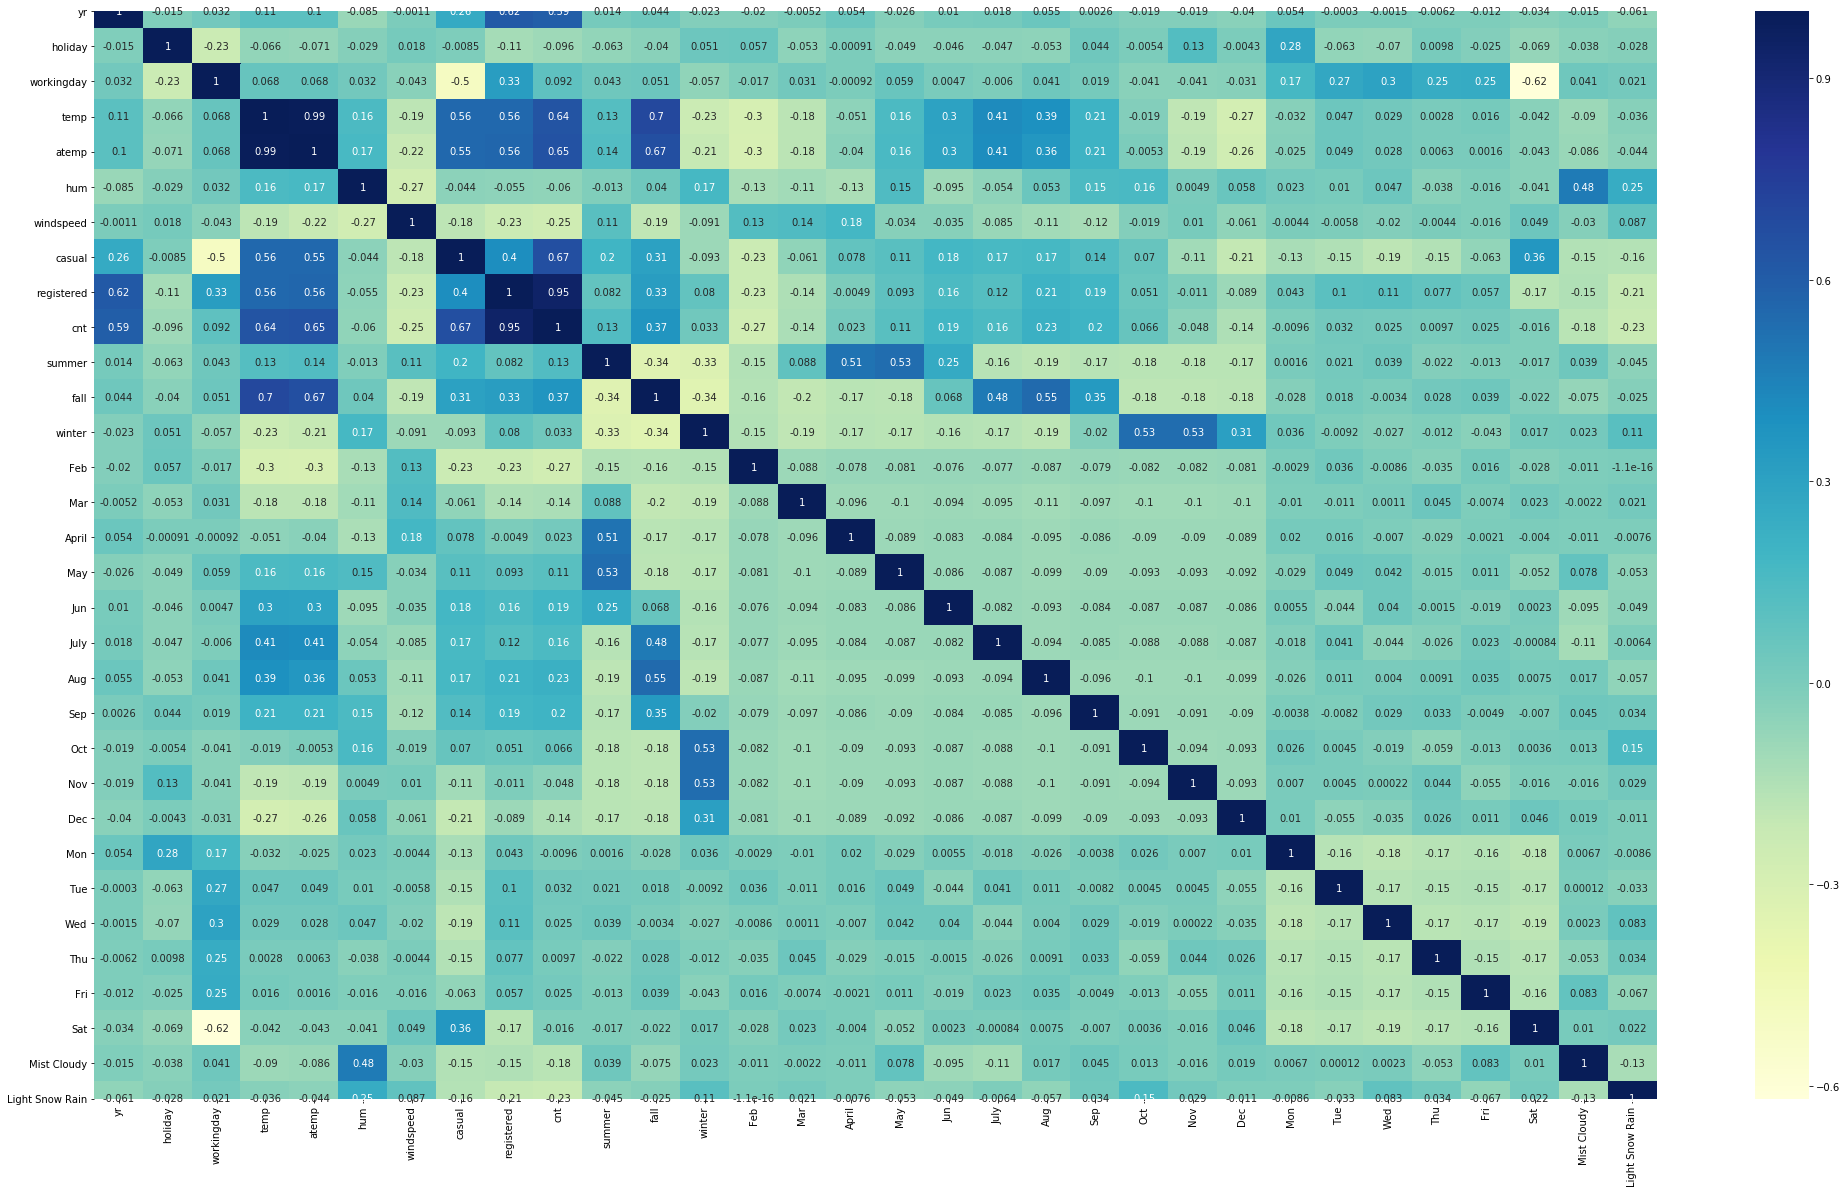

In [377]:
# Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (35, 20))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

### Dividing into X and Y sets for the model building

In [469]:
y_train = df_train.pop('cnt')
X_train = df_train

## Building our model

This time, we will be using the **LinearRegression function from SciKit Learn** for its compatibility with RFE (which is a utility from sklearn)

### RFE
Recursive feature elimination

In [470]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 15)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [471]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', False, 3),
 ('casual', True, 1),
 ('registered', True, 1),
 ('summer', True, 1),
 ('fall', True, 1),
 ('winter', True, 1),
 ('Feb', True, 1),
 ('Mar', False, 17),
 ('April', False, 13),
 ('May', False, 11),
 ('Jun', False, 14),
 ('July', False, 15),
 ('Aug', False, 16),
 ('Sep', False, 6),
 ('Oct', True, 1),
 ('Nov', False, 8),
 ('Dec', False, 5),
 ('Mon', True, 1),
 ('Tue', False, 9),
 ('Wed', False, 4),
 ('Thu', True, 1),
 ('Fri', False, 2),
 ('Sat', False, 12),
 ('Mist Cloudy', False, 10),
 ('Light Snow Rain', False, 7)]

In [472]:
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'casual',
       'registered', 'summer', 'fall', 'winter', 'Feb', 'Oct', 'Mon', 'Thu'],
      dtype='object')

In [473]:
X_train.columns[~rfe.support_]

Index(['windspeed', 'Mar', 'April', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Nov',
       'Dec', 'Tue', 'Wed', 'Fri', 'Sat', 'Mist Cloudy', 'Light Snow Rain'],
      dtype='object')

### Building model using statsmodel, for the detailed statistics

In [474]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [475]:
# Adding a constant variable  
X_train_rfe = sm.add_constant(X_train_rfe)

In [476]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

In [477]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.013e+30
Date:                Mon, 15 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:10:37   Log-Likelihood:                 17116.
No. Observations:                 510   AIC:                        -3.420e+04
Df Residuals:                     494   BIC:                        -3.413e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.021e-17    1.7e-16     -0.531      0.5

`Feb` is insignificant in presence of other variables; can be dropped

In [478]:
X_train_new = X_train_rfe.drop(["Feb"], axis = 1)

Rebuilding the model without `Feb`

In [479]:
# Adding a constant variable  
X_train_lm = sm.add_constant(X_train_new)

In [480]:
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model

In [481]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.680e+30
Date:                Mon, 15 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:10:42   Log-Likelihood:                 16995.
No. Observations:                 510   AIC:                        -3.396e+04
Df Residuals:                     495   BIC:                        -3.390e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.388e-17   2.08e-16      0.067      0.9

`Thu` is insignificant in presence of other variables; can be dropped

In [482]:
X_train_new_1 = X_train_new.drop(["Thu"], axis = 1)

In [483]:
# Adding a constant variable   
X_train_lm_1 = sm.add_constant(X_train_new_1)

In [484]:
lm_1 = sm.OLS(y_train,X_train_lm_1).fit()   # Running the linear model

In [485]:
#Let's see the summary of our linear model
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.692e+30
Date:                Mon, 15 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:10:48   Log-Likelihood:                 17276.
No. Observations:                 510   AIC:                        -3.452e+04
Df Residuals:                     496   BIC:                        -3.446e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.551e-16   1.19e-16      4.646      0.0

In [486]:
X_train_new_2 = X_train_new_1.drop(["temp"], axis = 1)

In [487]:
# Adding a constant variable   
X_train_lm_2 = sm.add_constant(X_train_new_2)

In [488]:
lm_2 = sm.OLS(y_train,X_train_lm_2).fit()   # Running the linear model

In [489]:
#Let's see the summary of our linear model
print(lm_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.748e+30
Date:                Mon, 15 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:10:51   Log-Likelihood:                 16846.
No. Observations:                 510   AIC:                        -3.367e+04
Df Residuals:                     497   BIC:                        -3.361e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.58e-16   2.76e-16      1.658      0.0

In [490]:
X_train_new_3 = X_train_new_2.drop(["hum"], axis = 1)

In [491]:
# Adding a constant variable   
X_train_lm_3 = sm.add_constant(X_train_new_3)

In [492]:
lm_3 = sm.OLS(y_train,X_train_lm_3).fit()   # Running the linear model

In [493]:
#Let's see the summary of our linear model
print(lm_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.668e+31
Date:                Mon, 15 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:10:55   Log-Likelihood:                 17518.
No. Observations:                 510   AIC:                        -3.501e+04
Df Residuals:                     498   BIC:                        -3.496e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0   4.77e-17          0      1.0

In [494]:
X_train_new_4 = X_train_new_3.drop(["Oct"], axis = 1)

In [495]:
# Adding a constant variable   
X_train_lm_4 = sm.add_constant(X_train_new_4)

In [496]:
lm_4 = sm.OLS(y_train,X_train_lm_4).fit()   # Running the linear model

In [497]:
#Let's see the summary of our linear model
print(lm_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.838e+30
Date:                Mon, 15 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:10:58   Log-Likelihood:                 17106.
No. Observations:                 510   AIC:                        -3.419e+04
Df Residuals:                     499   BIC:                        -3.414e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0   1.06e-16          0      1.0

In [498]:
X_train_new_5 = X_train_new_4.drop(["yr"], axis = 1)

In [499]:
# Adding a constant variable   
X_train_lm_5 = sm.add_constant(X_train_new_5)

In [500]:
lm_5 = sm.OLS(y_train,X_train_lm_5).fit()   # Running the linear model

In [501]:
#Let's see the summary of our linear model
print(lm_5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.002e+30
Date:                Mon, 15 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:11:01   Log-Likelihood:                 16806.
No. Observations:                 510   AIC:                        -3.359e+04
Df Residuals:                     500   BIC:                        -3.355e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -2.8e-15   1.87e-16    -14.943      0.0

In [502]:
X_train_new_6 = X_train_new_5.drop(["atemp"], axis = 1)

In [503]:
# Adding a constant variable   
X_train_lm_6 = sm.add_constant(X_train_new_6)

In [504]:
lm_6 = sm.OLS(y_train,X_train_lm_6).fit()   # Running the linear model

In [505]:
#Let's see the summary of our linear model
print(lm_6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.340e+31
Date:                Mon, 15 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:11:04   Log-Likelihood:                 17260.
No. Observations:                 510   AIC:                        -3.450e+04
Df Residuals:                     501   BIC:                        -3.446e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.076e-15   6.87e-17    -15.645      0.0

In [506]:
X_train_new_7 = X_train_new_6.drop(["workingday"], axis = 1)

In [507]:
# Adding a constant variable   
X_train_lm_7 = sm.add_constant(X_train_new_7)

In [508]:
lm_7 = sm.OLS(y_train,X_train_lm_7).fit()   # Running the linear model

In [509]:
#Let's see the summary of our linear model
print(lm_7.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.712e+31
Date:                Mon, 15 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:11:07   Log-Likelihood:                 17288.
No. Observations:                 510   AIC:                        -3.456e+04
Df Residuals:                     502   BIC:                        -3.453e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.233e-16   5.49e-17      7.712      0.0

In [510]:
X_train_new_8 = X_train_new_7.drop(["winter"], axis = 1)

In [511]:
# Adding a constant variable   
X_train_lm_8 = sm.add_constant(X_train_new_8)

In [512]:
lm_8 = sm.OLS(y_train,X_train_lm_8).fit()   # Running the linear model

In [513]:
#Let's see the summary of our linear model
print(lm_8.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.607e+30
Date:                Mon, 15 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:11:11   Log-Likelihood:                 16645.
No. Observations:                 510   AIC:                        -3.328e+04
Df Residuals:                     503   BIC:                        -3.325e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.158e-15   1.88e-16    -11.478      0.0

In [514]:
X_train_new_9 = X_train_new_8.drop(["holiday"], axis = 1)

In [515]:
# Adding a constant variable   
X_train_lm_9 = sm.add_constant(X_train_new_9)

In [516]:
lm_9 = sm.OLS(y_train,X_train_lm_9).fit()   # Running the linear model

In [517]:
#Let's see the summary of our linear model
print(lm_9.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.170e+31
Date:                Mon, 15 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:11:14   Log-Likelihood:                 17600.
No. Observations:                 510   AIC:                        -3.519e+04
Df Residuals:                     504   BIC:                        -3.516e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.735e-16   2.86e-17      6.056      0.0

In [518]:
X_train_new_10 = X_train_new_9.drop(["Mon"], axis = 1)

In [519]:
# Adding a constant variable   
X_train_lm_10 = sm.add_constant(X_train_new_10)

In [520]:
lm_10 = sm.OLS(y_train,X_train_lm_10).fit()   # Running the linear model

In [521]:
#Let's see the summary of our linear model
print(lm_10.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.342e+31
Date:                Mon, 15 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:11:17   Log-Likelihood:                 17381.
No. Observations:                 510   AIC:                        -3.475e+04
Df Residuals:                     505   BIC:                        -3.473e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.608e-16   4.35e-17      8.301      0.0

# Check for the VIF values of the feature variables. 

We generally want a VIF that is less than 5. So there are clearly some variables we need to drop.

In [522]:
X_train_new_10.columns

Index(['const', 'casual', 'registered', 'summer', 'fall'], dtype='object')

In [523]:
X_train_new_11 = X_train_new_10.drop(['const'], axis=1)

In [524]:
vif = pd.DataFrame()
X = X_train_new_11
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
1  registered  3.46
0      casual  3.38
3        fall  1.97
2      summer  1.70

## Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [525]:
y_train_cnt = lm_10.predict(X_train_lm_10)

In [526]:
# Importing the required libraries for plots.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 0, 'Errors')

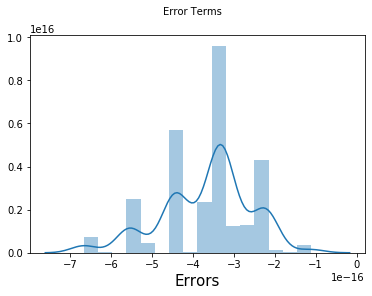

In [527]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt))
fig.suptitle('Error Terms', fontsize = 10)                  # Plot heading 
plt.xlabel('Errors', fontsize = 15)                         # X-label

In [528]:
num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

In [529]:
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [530]:
y_test = df_test.pop('cnt')
X_test = df_test

In [532]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new_11.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)


In [533]:
# Making predictions
y_pred = lm_10.predict(X_test_new)

Text(0, 0.5, 'y_pred')

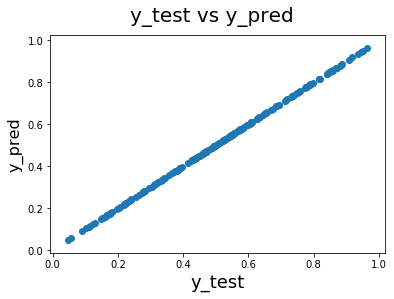

In [534]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label